In [1]:
#ToDos
#-generate dummy data and train the net on it, check if you get T, dqdt, q
#---> if not make dummy net on dummy data and benchmark the odeint
#-train separate time net then integrate it into the bigger net
#-

#Problems
#-math trafos between scaled and unscaled t and y axis, very tricky
#-ode int with starting y0=0 then added y0
#-Time not predicting well, but this is needed for proper time rescalings!!
#-unnecessary broadcastings of Tep, we got 32x32 minus 32,1 and that was crap
#-

#Idea
#-pretrain on time_net separately then joint train

In [2]:
import sys
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils import *
# from torchsummary import summary
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import os      
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"   

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#Data Loader
I_train, I_test, _, _, Tep_train, Tep_test, q_us_train, q_us_test, dqdt_us_train, dqdt_us_test = load_data()

Tep_train = Tep_train.double()
Tep_test = Tep_test.double()
I_train = I_train.double()
I_test = I_test.double()
q_us_train = q_us_train.double()
q_us_test = q_us_test.double()
dqdt_us_train = dqdt_us_train.double()
dqdt_us_test = dqdt_us_test.double()

#--- q scaled ---
q_mu = torch.mean(q_us_train)
q_sigma = torch.std(q_us_train)

q_sc_train = (q_us_train - q_mu) / q_sigma
q_sc_test = (q_us_test - q_mu) / q_sigma

#--- dqdt scaled ---
dqdt_mu = torch.mean(dqdt_us_train)
dqdt_sigma = torch.std(dqdt_us_train)

dqdt_sc_train = (dqdt_us_train - dqdt_mu) / dqdt_sigma
dqdt_sc_test = (dqdt_us_test - dqdt_mu) / dqdt_sigma


In [34]:
m_I = I_train.mean()
s_I = I_train.std()

In [38]:
((I_test - m_I) / s_I).max()

tensor(1.3667, device='cuda:0', dtype=torch.float64)

In [4]:
class Time_net(nn.Module):
    def __init__(self):
        super(Time_net, self).__init__()
        
        self.time_net = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 15),
            nn.ReLU(),
            nn.Linear(15, 1),
        ).double()
        
        self.is_train_time(True)
    
    def forward(self, Is):
        Ts = self.time_net(Is)
        
        return Ts
    
    def is_train_time(self, is_trainable):
        for param in self.time_net.parameters():
            param.requires_grad = is_trainable
            
        self.time_train = is_trainable


In [5]:
#Testing Net for dummy inputs and y0s
t = torch.tensor(2/50,dtype=torch.float64).to(device)
y0 = torch.ones(32,dtype=torch.float64).to(device)
Is = torch.randn(32,30,dtype=torch.float64).to(device)

In [6]:
net = Time_net().to(device).double()

In [10]:

batch_size = 32
epochs = 100

# net.train()
batch_t_scaled = ( torch.arange(1,51)/50 ).to(device).double()
net.is_train_time(True) # True False



optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)


for epoch in range(1, epochs + 1):
    trainloader = torch.utils.data.DataLoader(
                                        torch.arange(len(I_train)), 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        drop_last=True)
    running_loss = 0
    for i, batch_indxs in enumerate(trainloader, 0):
        Tep_target_batch = Tep_train[batch_indxs]
                
        Is = I_train[batch_indxs]

        Tep_pred = net( Is )
        Tep_loss = torch.nn.MSELoss()(Tep_pred.squeeze() , Tep_target_batch)
        loss = Tep_loss
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        percent = (i + 1) / len(trainloader) * 100
        print(f'Epoch {epoch} \t{loss.item():.5f}\t{percent:.0f}%', end='\r')
        sys.stdout.flush()
    print('\nAverage loss =', running_loss / len(trainloader))

Epoch 1 	0.00040	100%
Average loss = 0.0005195166272270552
Epoch 2 	0.00035	100%
Average loss = 0.0005182200505228941
Epoch 3 	0.00067	100%
Average loss = 0.0005180086503798503
Epoch 4 	0.00034	100%
Average loss = 0.0005177778124361959
Epoch 5 	0.00058	100%
Average loss = 0.0005175508328633121
Epoch 6 	0.00035	100%
Average loss = 0.0005174245659170458


KeyboardInterrupt: 

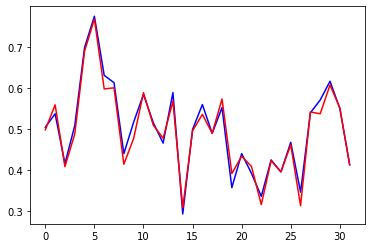

In [11]:
net.eval()

plt.plot(Tep_pred.detach().cpu(), 'b')
plt.plot(Tep_target_batch.detach().cpu(),'r');

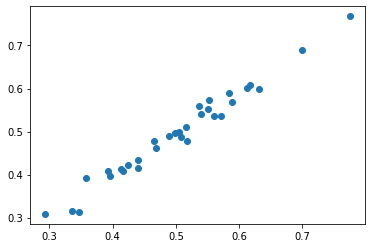

In [12]:
plt.plot(Tep_pred.detach().cpu(),Tep_target_batch.detach().cpu(), 'o');  #this must be a id_func

In [14]:
torch.save(net.state_dict(), './models/time_net.pth')

In [15]:
model = Time_net().to(device)
model.load_state_dict(torch.load('./models/time_net.pth'))
model.eval()

Time_net(
  (time_net): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
  )
)

Loss = 0.0004973796836915599


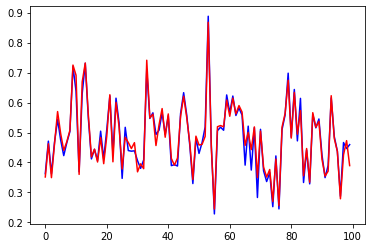

In [22]:
T_pred = model(I_test[:100]).squeeze()

T_true = Tep_test[:100]

plt.plot(T_pred.detach().cpu(), 'b')
plt.plot(T_true.detach().cpu(), 'r');

print('Loss =', torch.nn.MSELoss()(T_pred, T_true).item())